# Applied NLP: A painless introduction to text analysis through earning call transcripts
We will be using this notebook to demonstrate some techniques for text analysis (vulgo NLP) on earning call transcripts of public companies. Rather than use sample text, we will use a rich source of text that is both rich enough and not too large to be treated in a local laptop.

## Intro to NLP

For simplicity, we will assume three steps on our NLP pipeline: Processing, feature extraction, and modelling. In fact before we model anything, we need to take into consideration two empirically verified assumptions:
1) Text is often, by its unstructured nature, noisy.
2) Models work best when data has been de-noised (e.g. try to use Computer Vision application with singificantly blurred images).

So before we are in a position to apply models to text tasks, we need to take some time processing the raw text. Let us now see what are the normal steps when we deal with Text Processing.


### 1. Text Processing

We are going to assume the following sequence of steps:

1) **Normalize by case**: Here, transform all the text to lower caps. If we are still working with a single string, we can use a single command once (str.lower()) to do that.

2) **Remove Punctutation**: This can assume different forms, but one may simply start with removing commas. This will preserve the sentence organization.

3) **Tokenization**: Until now, text was a single string, we now want to split it into sentences and words.

4) **Remove Stop Words**: Remove some of the most common words such as "and" or "this". It can also be tweaked to a specific domain.

5) **Steming/Lemmatization (Optional)**: To reduced complexity, we can try to reduce related words to a common root word using Steming or Lemmatization. While Stemming reduces complexity by tryng to find a common stem around words, Lemmatization uses a known mapping to reduce words to their base form, usually depending on the syntatic function of the word (verb, noun, adverb). Note that while Lemmatization produces meaningful words, stemming may not do that.

These steps assume that we start with a raw piece of text that we progressively clean, noramlize, tokenize or split into into words, remove 'noise' in the form of frequently used words, and then try to organize words around common stems.


Let us start with loading a transcript of a sample earnings call. For the purpose, we will use Nvidia's last quarter transcript.

In [10]:
from aux import extract_call_transcript #Auxilliary function to call the API for earnings transcript
doc = extract_call_transcript('NVDA', 1, 2021) 

print(f' The transcript of the call is {len(doc)} characters long')

 The transcript of the call is 76794 characters long


If we assume that a page of single spaced text usually contains around 3000 characters, this transcript is 
around 25 pages long. Let us see read the first and last 1000 characters of the string.

In [39]:
opening_doc = doc[:1000]
closing_doc = doc[-1000:]

print('*'*107)
print(f'The opening first 1000 characters\n\n{opening_doc}')

print('*'*107)
print(f'The closing last 1000 characters\n\n {closing_doc}')

***********************************************************************************************************
The opening first 1000 characters

Operator: Good afternoon. My name is Josh, and I will be your conference operator today. At this time, I would like to welcome everyone to NVIDIA's Financial Results Conference call. [Operator Instructions].Simona Jankowski, you may begin your conference.
Simona Jankowski: Thank you. Good afternoon, everyone, and welcome to NVIDIA's conference call for the first quarter of fiscal 2021. With me on the call today from NVIDIA are Jensen Huang, President and Chief Executive Officer; and Colette Kress, Executive Vice President and Chief Financial Officer. I'd like to remind you that our call is being webcast live on NVIDIA's Investor Relations website. The webcast will be available for replay until the conference call to discuss our financial results for the second quarter of fiscal 2021. The content of today's call is NVIDIA's property. It can't be 

otice how the call opens and closes with the operator. Also, notice the spacing after the end of sentences is not uniform. One can also see the presence of the element '[Operator Instructions]' to cue a speaker. 

### 1.1 Normalization with str.lower()

Before we attempt any processing, let's just analyze the number of unique characters that the opening string contains.

In [41]:
opening_doc_unique = set(opening_doc)
print(f'There are {len(opening_doc_unique)} unique characters')

There are 56 unique characters


Let us see now what happens when we normalize the strings with str.lower().

In [46]:
doc_norm = doc.lower()
opening_doc_norm = doc_norm[:1000]
opening_doc_norm_unique = set(opening_doc_norm)
print(f'There are {len(opening_doc_norm_unique)} unique characters after normalization.')

There are 38 unique characters after normalization.


This reduction in the number of unique characters will translate to a reduction in the number of unique words, when we move to tokenization.

### 1.2 Punctuation
Let us start by looking at the list of unique characters, and check what we have there.

In [86]:
import re
temp = ''.join(opening_doc_norm_unique)

el = re.sub(r'[a-z-0-9]', '', temp) # Keep only non alphanumerics
print(f'The non-alphanumeric characters found {repr(el)}') # Use repr to escape special characters

The non-alphanumeric characters found ";[]\n,': ."


 For simplicity let us only remove commas and the special character \n.

In [85]:
doc_norm_cleaned = re.sub(r'[,\n]', "", doc_norm)
print('Raw text')
print(doc[:300])
print('*'*107)
print('\nCleaned and normalized')
print(doc_norm_cleaned[:300])

Raw text
Operator: Good afternoon. My name is Josh, and I will be your conference operator today. At this time, I would like to welcome everyone to NVIDIA's Financial Results Conference call. [Operator Instructions].Simona Jankowski, you may begin your conference.
Simona Jankowski: Thank you. Good afternoon,
***********************************************************************************************************

Cleaned and normalized
operator: good afternoon. my name is josh and i will be your conference operator today. at this time i would like to welcome everyone to nvidia's financial results conference call. [operator instructions].simona jankowski you may begin your conference.simona jankowski: thank you. good afternoon ever


As expected, commas have been removed. Let us now move to tokenization.

### 1.3 Tokenization

Before we we will start by doing a sentence tokenization, that is split the string into strings. For that we will use the Punkt Sentence Tokenizer from Nltk

In [96]:
#import nltk.data
sent_tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
doc_norm_cleaned_sentencized = sent_tokenizer.tokenize(doc_norm_cleaned)
print(f'{len(doc_norm_cleaned_sentencized)} Sentences Identified')
print('The first 10 sentences:')
doc_norm_cleaned_sentencized[:10]

693 Sentences Identified
The first 10 sentences:


['operator: good afternoon.',
 'my name is josh and i will be your conference operator today.',
 "at this time i would like to welcome everyone to nvidia's financial results conference call.",
 '[operator instructions].simona jankowski you may begin your conference.simona jankowski: thank you.',
 "good afternoon everyone and welcome to nvidia's conference call for the first quarter of fiscal 2021. with me on the call today from nvidia are jensen huang president and chief executive officer; and colette kress executive vice president and chief financial officer.",
 "i'd like to remind you that our call is being webcast live on nvidia's investor relations website.",
 "the webcast will be available for replay until the conference call to discuss our financial results for the second quarter of fiscal 2021. the content of today's call is nvidia's property.",
 "it can't be reproduced or transcribed without our prior written consent.during this call we may make forward-looking statements based

We can see that now we have a list of sentences, where each sentence is an unstructured string.

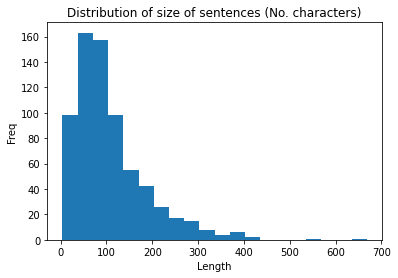

In [105]:
import matplotlib.pyplot as plt
counter_chars = [len(sen) for sen in doc_norm_cleaned_sentencized]
plt.hist(counter_chars, bins=20)
plt.title('Distribution of size of sentences (No. characters)')
plt.xlabel('Length')
plt.ylabel('Freq')
plt.show()

Interestingly, there seams to be a skew to the left in the distribution of the size of the sentences. Let us see how this translates when we move to word tokenization.

### 1.3.2 Work Tokenization
The package nltk contains several word tokenizers. Here, we will use the Twitter Tokenizer, which is a basic tokenizer trained to detect handles.

In [122]:
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()
# Remove the dot in the sentences
doc_norm_cleaned_sentencized_tokenized = [tokenizer.tokenize(sent.replace('.', "")) for sent in doc_norm_cleaned_sentencized]
for sent in doc_norm_cleaned_sentencized_tokenized[:5]:
    print(sent)

['operator', ':', 'good', 'afternoon']
['my', 'name', 'is', 'josh', 'and', 'i', 'will', 'be', 'your', 'conference', 'operator', 'today']
['at', 'this', 'time', 'i', 'would', 'like', 'to', 'welcome', 'everyone', 'to', "nvidia's", 'financial', 'results', 'conference', 'call']
['[', 'operator', 'instructions', ']', 'simona', 'jankowski', 'you', 'may', 'begin', 'your', 'conferencesimona', 'jankowski', ':', 'thank', 'you']
['good', 'afternoon', 'everyone', 'and', 'welcome', 'to', "nvidia's", 'conference', 'call', 'for', 'the', 'first', 'quarter', 'of', 'fiscal', '2021', 'with', 'me', 'on', 'the', 'call', 'today', 'from', 'nvidia', 'are', 'jensen', 'huang', 'president', 'and', 'chief', 'executive', 'officer', ';', 'and', 'colette', 'kress', 'executive', 'vice', 'president', 'and', 'chief', 'financial', 'officer']


Let us see how the distribution of the lenght of the strings is when measured by the number of words.

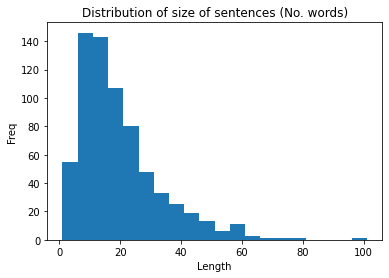

In [415]:
count_words = [len(sen) for sen in doc_norm_cleaned_sentencized_tokenized]
plt.hist(count_words, bins=20)
plt.title('Distribution of size of sentences (No. words)')
plt.xlabel('Length')
plt.ylabel('Freq')
plt.show()

As expected, there is a high correlation between the number of characters a sentence contains and the number of words. This probably due to the distribution of the length of the words across the document.

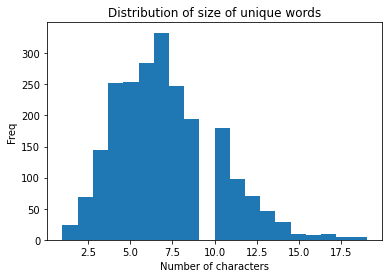

In [150]:
bag_words = tokenizer.tokenize(re.sub(r'([.,:;-])', '', doc_norm_cleaned)) #Tokenize into words
#/([!?\,\.])/g
unique_words = list(set(bag_words))
unique_words_len = [len(w) for w in unique_words]
plt.hist(unique_words_len, bins=20)
plt.title('Distribution of size of unique words')
plt.xlabel('Number of characters')
plt.ylabel('Freq')
plt.show()

### 1.4 Stop Words

Calculate the frequency of the top 30 words and show in a plot.

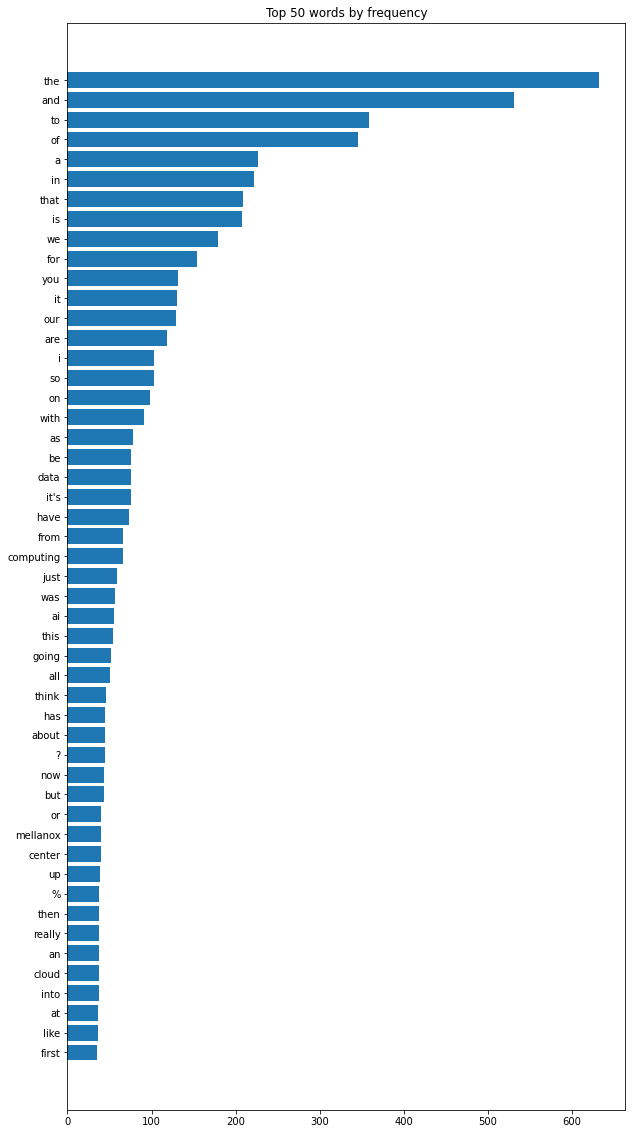

In [185]:
from collections import Counter
import numpy as np
count_words = Counter(bag_words)
top_words = np.array(count_words.most_common(50))
fig, ax = plt.subplots(figsize=(10,20))
ax.barh(np.flip(top_words[:,0]), np.flip(top_words[:,1]).astype(np.int32))
plt.title('Top 50 words by frequency')
plt.show()

Let us see how this compares with some stopwords from nltk.

In [191]:
from nltk.corpus import stopwords
nltk.download("stopwords")
stop = stopwords.words("english")
intersect  = set(stop).intersection(set(top_words[:,0]))
print(f'There are {len(intersect)} common stop words: {intersect}')

There are 37 common stop words: {'on', 'the', 'this', "it's", 'then', 'into', 'a', 'have', 'has', 'that', 'an', 'up', 'from', 'all', 'just', 'in', 'or', 'for', 'are', 'of', 'with', 'as', 'be', 'but', 'to', 'you', 'now', 'it', 'is', 'at', 'and', 'so', 'our', 'we', 'was', 'i', 'about'}


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sapereira/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


We can see that out of 50 top words, 37 are contained in the nltk stop words. Let's remove them.

In [195]:
doc_processed = [ [w for w in s if w not in stop] for s in doc_norm_cleaned_sentencized_tokenized] 

### 1.5 Stemming and Lemmatization
Here we apply a common Stemmer, the PorterStemmer from NLTk.

Let us now move to the feature extraction.

## 2. Feature Extraction

Since models do not work with words directly, we have to transform them somehow into tokens that can be read by models. The way to do this is generally to transformterms or sentences into vector-representations.

### 2.1 Bag of Words
Bag of words constructs an array of dimension #{Sentences} $\times$ #{unique_words} of 0s and 1s based on whether a certain word is present in the sentence.

In [215]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_bw = CountVectorizer() 
doc_bag_words = vectorizer_bw.fit_transform(doc_norm_cleaned_sentencized)
doc_bag_words

<693x2077 sparse matrix of type '<class 'numpy.int64'>'
	with 11116 stored elements in Compressed Sparse Row format>

Interestingly, it is saved as a sparse matrix, because a very large part of the elements are 0. Let us see how they look like.

In [364]:
features = vectorizer_bw.get_feature_names()
print(f'{len(features)} different features')
print(doc_bag_words.toarray())

2077 different features
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]]


Let us look at the last sentence, and verify that the element in the position -3 of the feature names is there.

In [214]:
print(doc_norm_cleaned_sentencized_tokenized[-1])
print(features[-3])

['you', 'may', 'now', 'disconnect']
you


Note that this model only indicates whether a word is present in a sentence. Better would be to have
some information about the frequency so that we can try to compute similarity of sentences based on the frequency of the distributions.

### 2.2 Term Frequency Times Inverse Document Frequency 
TF-IDF is based on the intitution that words that are more unique in a sentence (originally the name is "document" where document is the subunit of the document). Let us assume that our corpus is "the little little lion" "the little house", which gives us the features ("the", "little", "lion", "house"). We can then encode our documents into

$\begin{pmatrix}1 & 1 & 1 & 0 \\ 1 & 1 & 0 & 1\end{pmatrix}$

Now, as we have mentioned above, bag of words 
The way to calculate that is to use the original bag of words, but instead of using for encoding the presence we allow the following transformation:
1) The entries correspond to the frequency of the word in the sentence. So, "the little little lion" gets transformed into (1, 2, 1, 0) and "the little house" into (1,1,0,1). This can be accomplished by using the CountVectorizer from sklearn.

2) We could normalize these frequencies by the number of terms in the document, which then yields after stacking the two vectors,

$\begin{pmatrix} \frac14 & \frac12 & \frac14 & 0 \\ \frac13 & \frac13 & 0 & \frac13 \end{pmatrix}$

Now, we can see that the matrix above represents the density of the words across independent documents (the rows). In order to relate those frequencies with the overall distribution of the document, we need to weight those frequencies by "something" that considers the relation of the terms across different documents. This is what the Inverse Document Frequency does. However with a different nomalization from step 2. 

In the case of TFIDF, we multiply the original term frequency (the vectors in step 1 above) by the inverse document frequency which, for a term  in a  document $d_i$, $w_{d_i}$ is defined as the logarithm of the ratio between the number of total documents and the number of documents that contain $w_{d_i}$

$(\frac{#\{Documents\}}{#\{d \in D: w_{d_i}} \in d_i \}$



Thus the original BoW transformation becomes for ("the", "little", "lion", "house")

$\begin{pmatrix} 1 \cdot \log(\frac{2+1}{2 +1}) & 2  \cdot \log(\frac{2+1}{1 + 1}) & 1 \cdot \log(\frac{2+1}{2+1}) & 0 \\ 1 \cdot  log(\frac{2+1}{2 + 1}) & 1 \cdot  \log(\frac{2+1}{2 + 1}) & 0 & 1 \cdot \log(\frac{2+1}{1+1}) \end{pmatrix}$

Note how the count vectorizer is multiplying element-wise the log terms.

Finally, we just need to normalize the above rows by their l-2 or l-1 norm.

The default implementation from Sklearn is slightly different form this one, since it consists of the following additional steps:
* Add 1 to the both the denominator and numerator of fraction inside the logarithmic: This prevents division by zero in case new documents contain unseen words.
* It uses l-2 norm.



In [354]:
 toy_corpus = ['the little little house', 'the little lion']
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
toy_tfidifv = TfidfVectorizer()
toy_counterv = CountVectorizer()
toy_tfidf = toy_vectorizer.fit_transform(toy_corpus) 
toy_count = toy_counterv.fit_transform(toy_corpus)
toy_count_ar = toy_count.toarray()
toy_tfidf_ar = toy_tfidf.toarray()


print(f'Order of the features')
print(toy_counterv.get_feature_names())
print(f'\nCount Vectorizer output')
toy_count_ar = toy_count.toarray()
print(toy_count_ar)
print(f'\nSklearn TFIDF Vectorizer output')
print(toy_tfidf_ar)


Order of the features
['house', 'lion', 'little', 'the']

Count Vectorizer output
[[1 0 2 1]
 [0 1 1 1]]

Sklearn TFIDF Vectorizer output
[[0.53215436 0.         0.75726441 0.37863221]
 [0.         0.70490949 0.50154891 0.50154891]]


Let us now replicate the value of the output given by the sklearn. Note that the term frequency is given by the Count Vectorizer, so what we will be doing is applying a weighting scheme as described above.

In [352]:
N=len(toy_count_ar)# The number of documents
term_vec = (toy_count_ar > 0).astype(np.float32).sum(axis=0) # Calculate the term frequency
tfidf_toy = toy_count_ar *  (np.log((1+ N) * np.reciprocal(term_vec + 1)) + 1)
print(f'The number of occurunces of the words across all documents: {term_vec}')
print(f'\nThe TF-IDF components before normalization:\n {tfidf_toy}')
tfidf_norm = tfidf_toy/ np.linalg.norm(tfidf_toy, axis=1)[:, np.newaxis]
print(f'\nThe normalized TF-IDF componenets: \n {tfidf_norm}')

The number of occurunces of the words across all documents: [1. 1. 2. 2.]

The TF-IDF components before normalization:
 [[0.         1.40546513 2.         1.        ]
 [1.40546513 0.         1.         1.        ]]

The normalized TF-IDF componenets: 
 [[0.         0.53215436 0.75726441 0.37863221]
 [0.70490949 0.         0.5015489  0.5015489 ]]


We can see that the word "lion" is more unique than "house" given that the sentence from where it is extracted is longer. We can now move to our real exammple on the earning tanscript.

In [367]:
tfidf_vectorizer = TfidfVectorizer()
earnings_transformed = tfidf_vectorizer.fit_transform(doc_norm_cleaned_sentencized)
assert features == tfidf_vectorizer.get_feature_names() # We don't need to do this since the order is the same as the vecotrizer
freqs = earnings_transformed.toarray()

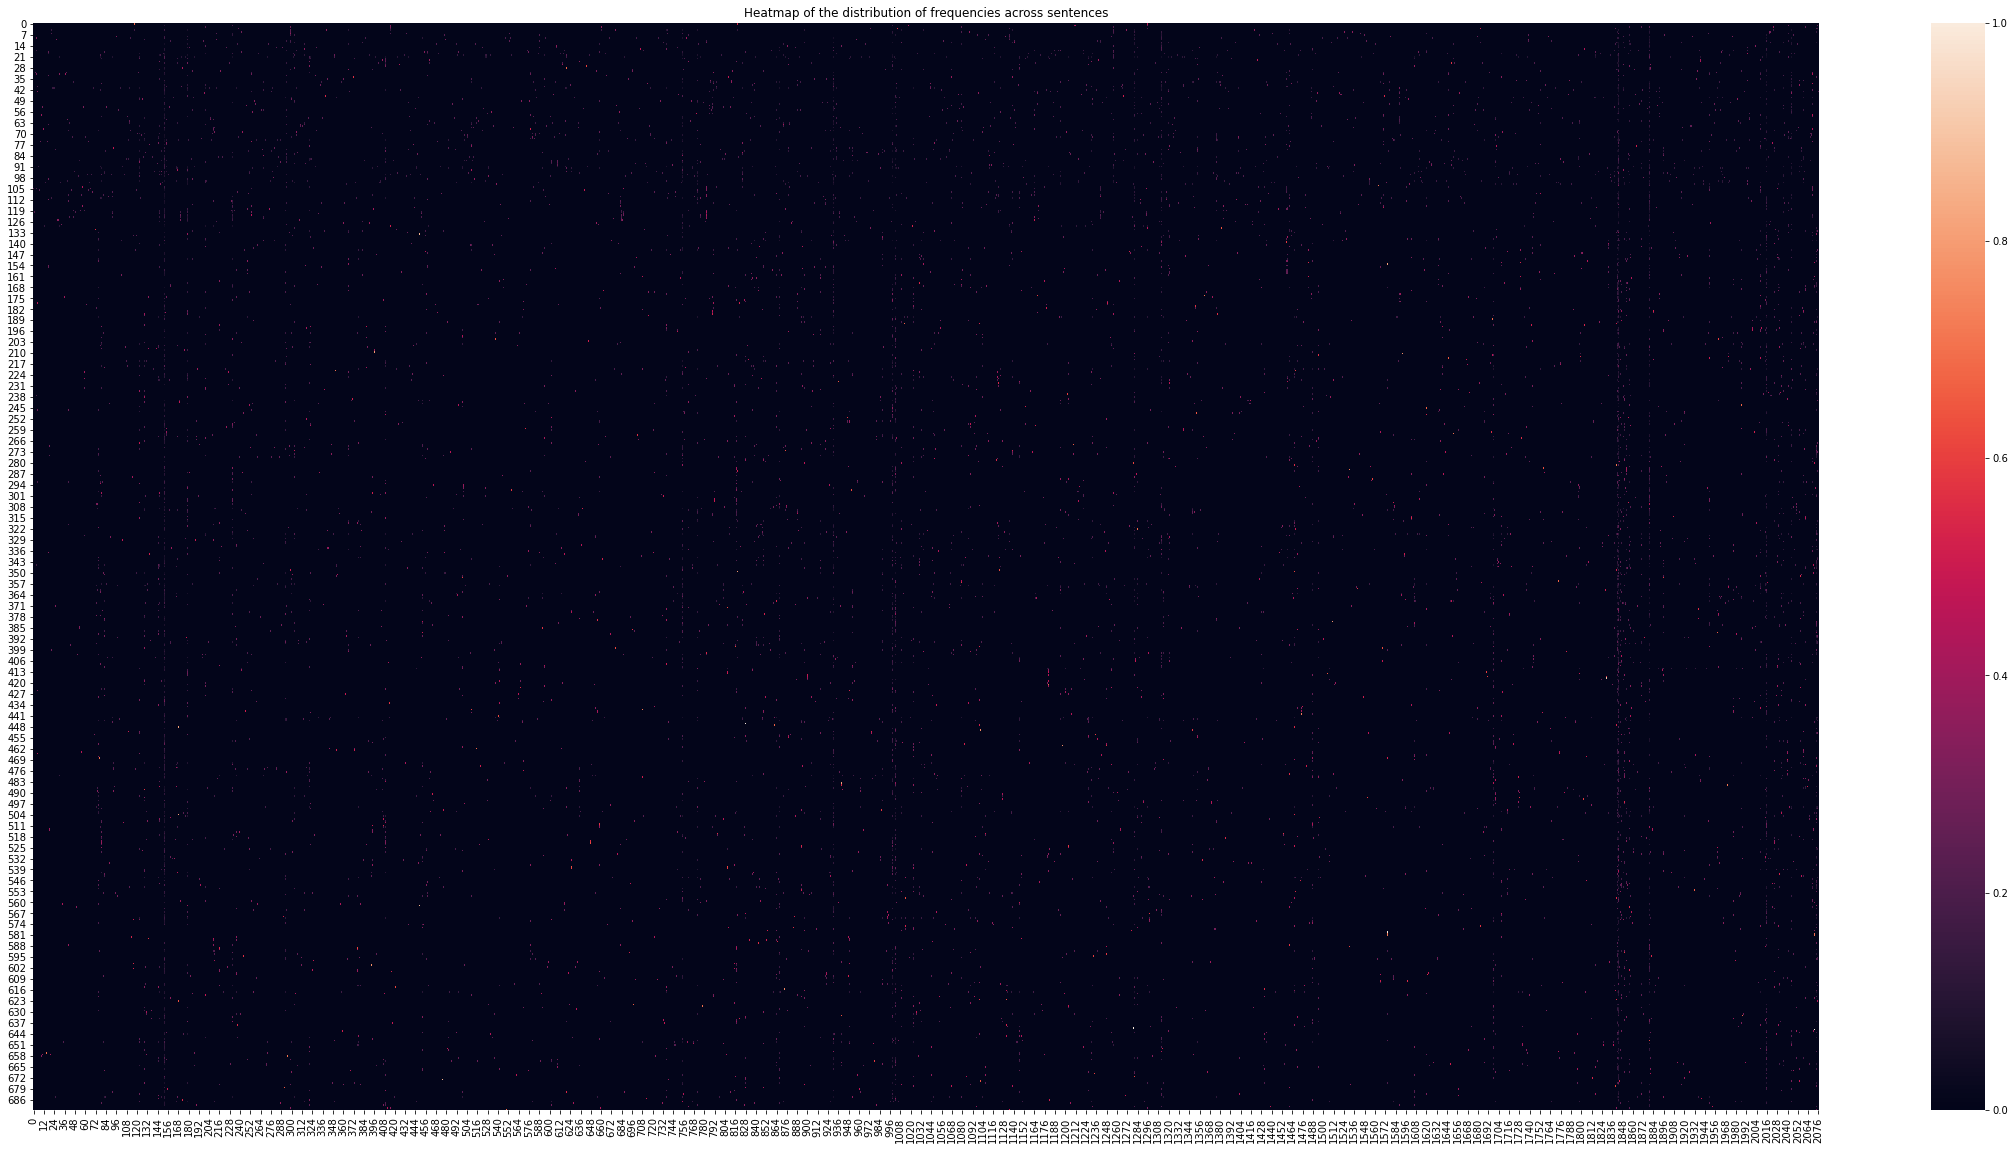

In [389]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(40,20))
ax = sns.heatmap(freqs)
plt.title('Heatmap of the distribution of frequencies across sentences')
plt.show()

We can see that preety much everything is zero, with some scattered light dots corresponding to higher frequencies. Let's zoom on the last 40 lines, where a bright dot seems to appear around sentence 630 for entery 1280-90.

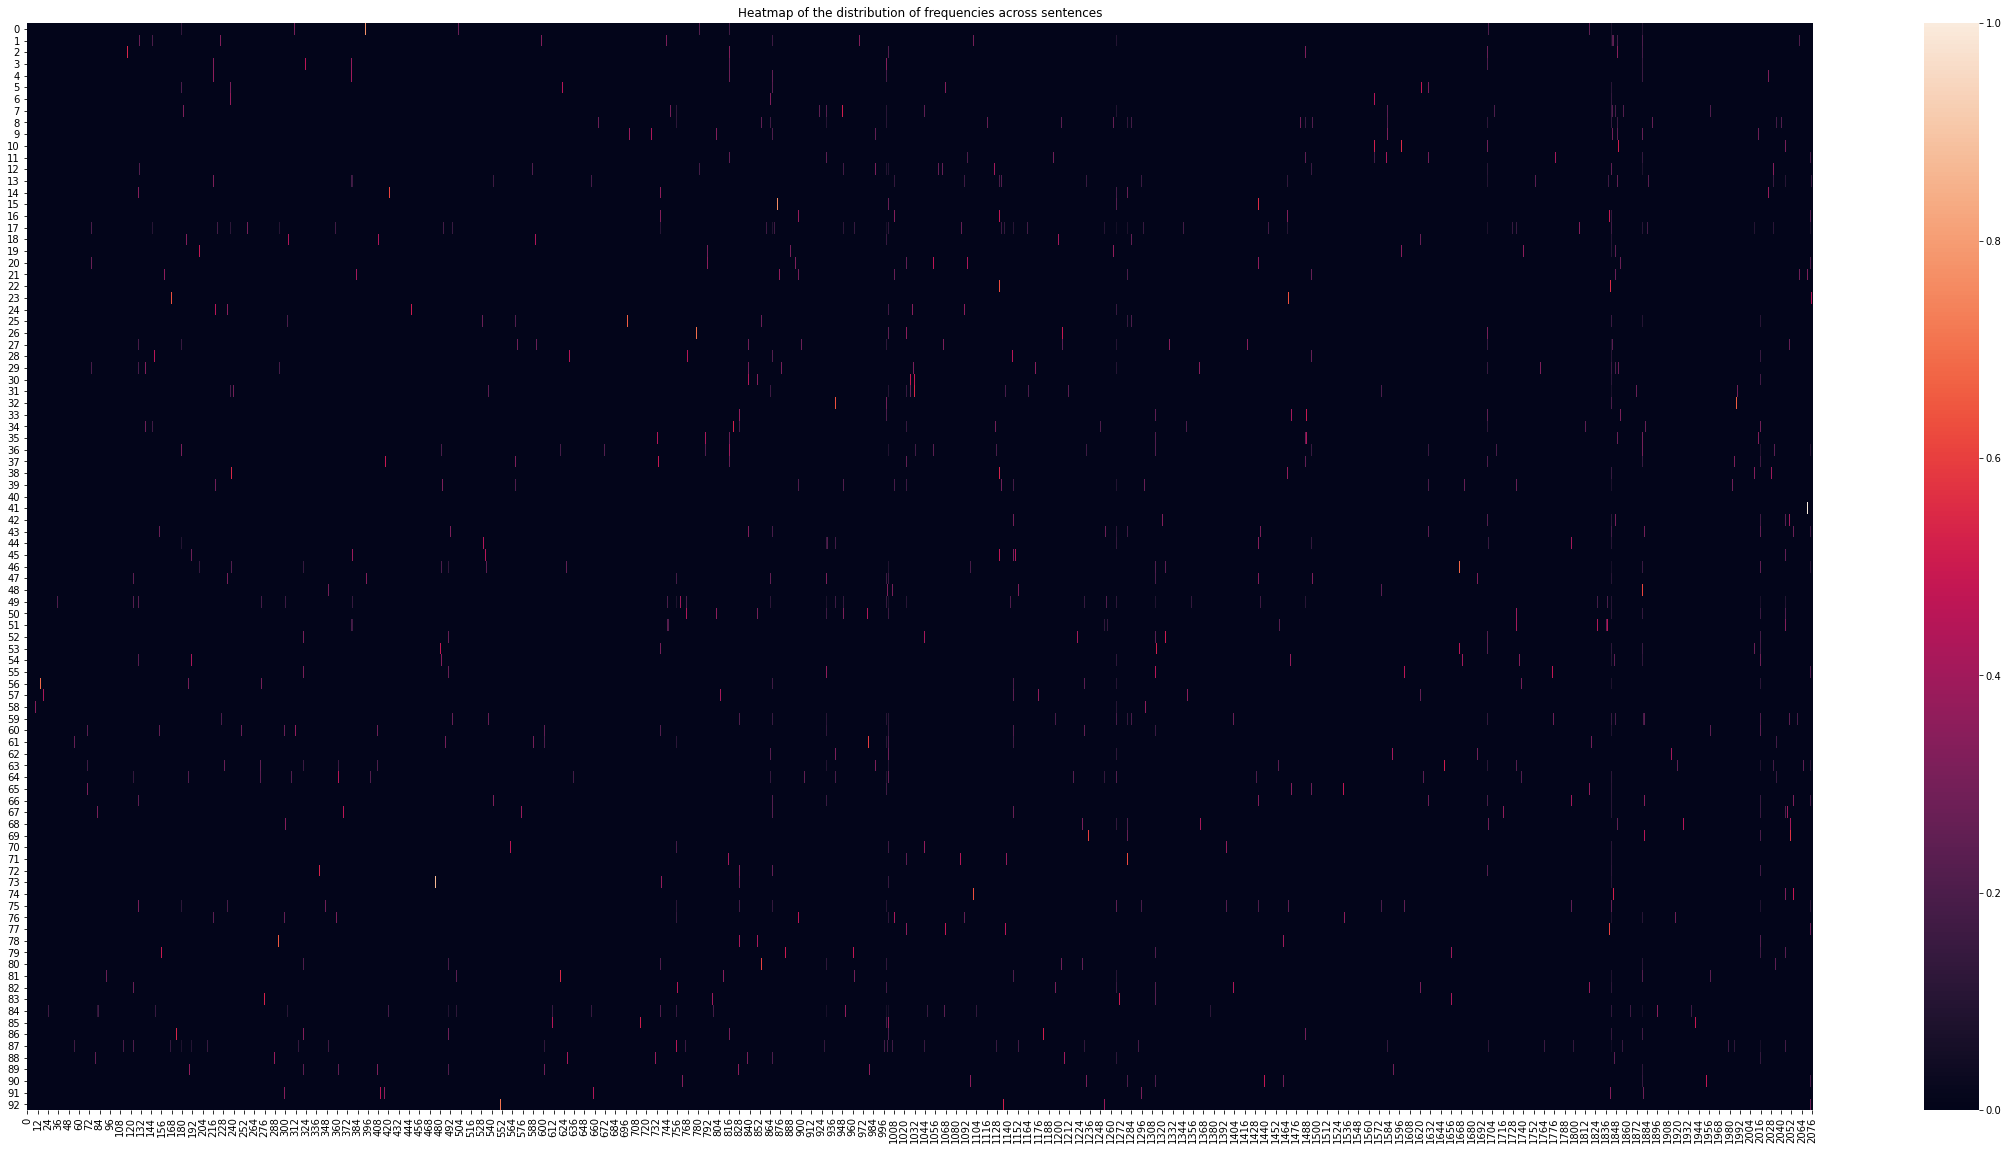

In [390]:
fig, ax = plt.subplots(figsize=(40,20))
ax = sns.heatmap(freqs[600:])
plt.title('Heatmap of the distribution of frequencies across sentences')
plt.show()

Instead of guessing let us which words are the most important and the corresponding sentences.

In [396]:
idx = np.unravel_index(np.argmax(freqs[600:], axis=None), freqs[600:].shape)
print(idx)

(40, 1279)


In [403]:
print(features[1279],doc_norm_cleaned_sentencized[640])

okay okay.


In [404]:
idx_max = np.unravel_index(np.argmax(freqs, axis=None), freqs.shape)
print(idx_max)

(446, 828)


In [417]:
doc_norm_cleaned_sentencized[446]


'great.'

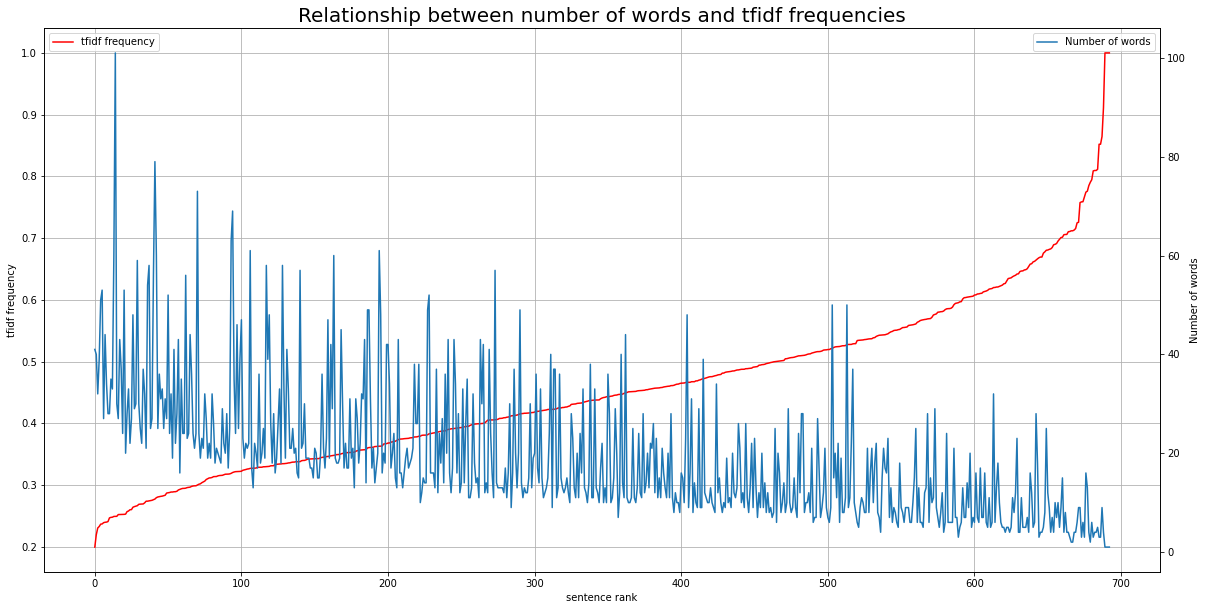

In [478]:
# Create an a vector with the maximum
max_freq_sentences = freqs.max(axis=1)
fig, ax1 = plt.subplots(figsize=(20,10))

# Sorte the count_words by the order corresponding to the max_fre
count_sorted_by_freq = np.array(count_words)[np.argsort(max_freq_sentences)]
ax1.set_xlabel('sentence rank')
ax1.set_ylabel('tfidf frequency')
ax1.plot(np.sort(max_freq_sentences), color='r', label='tfidf frequency')
ax1.grid()
ax1.legend(loc=2)

ax2 = ax1.twinx()
ax2.set_ylabel('Number of words')
ax2.plot(count_sorted_by_freq, label='Number of words')
ax2.legend(loc=0)


plt.title('Relationship between number of words and tfidf frequencies', fontsize=20)
plt.show()
#plt.plot(max_sentences)
#plt.plot(count_words)


There seems to be an inverse relationship between the number of words and tthe highest frequnency attained by any word in a sentence. This suggests that we may have to remove the influence of the size of the sentence from the importance of the word, or will have to have to factor that when making computations. As next step to encode text, is not encode group of tokens (i.e sentences into sparse vectors), but encode them into a fixed-dimensional space that preserve some expected properties such similarity for instance. That is the objective of the Embedding schemes, that is homeomorphisms between a Corpus and a subspace of the n-dimensional real space. Let us describe some of those.

In [ ]:
import spacy
from extractors import extract_call_transcript
import pandas as pd



# Load the Loughran-McDonlad sentiment words based on 10-k filings
# https://drive.google.com/file/d/15UPaF2xJLSVz8DYuphierz67trCxFLcl/view
word_map = pd.read_pickle('data/LM_Sentiment.pkl')
print(f'There is sentiment tagging for {word_map.shape[0]} words.')
obj = extract_call_transcript('TWTR',1, 2021)
text = obj[0].get('content')

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
#from transformers import pipeline
#sentiment_analysis = pipeline("sentiment-analysis",model="siebert/sentiment-roberta-large-english")




In [2]:
nlp = spacy.load("en_core_web_trf")
doc = nlp(text)

In [3]:
def analyze_sentiment(doc, word_map):
    tokens = [token.text.lower() for token in doc]
    tokens_map = word_map[word_map['Word'].isin(tokens)]
    return tokens_map


sentiment_freq = analyze_sentiment(doc, word_map)

In [4]:
sentiment_freq['Word'].values

array(['aftermath', 'against', 'concerned', 'confused', 'delay',
       'delayed', 'drag', 'exacerbated', 'failed', 'missed', 'opposed',
       'problem', 'question', 'questions', 'slow', 'slowed', 'slower',
       'slowness', 'urgency', 'worry', 'able', 'achieve', 'advantage',
       'benefiting', 'best', 'better', 'boost', 'confident', 'easier',
       'easily', 'easy', 'enabling', 'excited', 'exclusively', 'gain',
       'gaining', 'good', 'great', 'greater', 'highest', 'improve',
       'improved', 'improvement', 'improvements', 'improving',
       'opportunities', 'opportunity', 'pleased', 'positive',
       'positively', 'progress', 'solving', 'strength', 'strong',
       'stronger', 'success', 'successful', 'assumes', 'assuming',
       'believe', 'could', 'may', 'maybe', 'might', 'nearly', 'possible',
       'seems', 'sometimes', 'unidentified', 'unusual', 'varied', 'vary',
       'remediate', 'whatever', 'always', 'best', 'definitely', 'highest',
       'must', 'never', 'will'

In [5]:
#from nltk.lm.preprocessing import padded_everygram_pipeline
#train, vocab = padded_everygram_pipeline(2, text)

In [6]:
#nlp.add_pipe("sentencizer")
from spacy.lang.en.stop_words import STOP_WORDS
doc_2 = nlp(text)
text_split = [sent for sent in doc_2.sents]

In [7]:
text_split_2 = [[token.text.lower() for token in sent] for sent in doc_2.sents]

In [8]:
unique_sent =  word_map['Sentiment'].unique()
word_map_dict = {k: word_map[word_map['Sentiment'] == k]['Word'].unique() for k in unique_sent}
#print(word_map_dict)
sentiment_sentences = {k: [sent.text for sent in text_split if len(set([token.text.lower() for token in sent]).intersection(v)) > 0] for k, v in word_map_dict.items()}


In [9]:
from collections import Counter
count = Counter(sentiment_sentences)
for k, v in sentiment_sentences.items():
    print(k, len(v))


Negative 58
Positive 103
Uncertainty 43
Litigious 2
StrongModal 29
WeakModal 29
Constraining 1


In [11]:
def sentiment_sentences_n_degree(n, text_split):
    sentiment_sentences = {k: [sent.text for sent in text_split if
                               len(set([token.text.lower() for token in sent]).intersection(v)) >= n] for k, v in word_map_dict.items()}
    return sentiment_sentences

In [12]:
sentiment_2 = sentiment_sentences_n_degree(n=2, text_split=text_split)
for k, v in sentiment_2.items():
    print(k, len(v))

Negative 3
Positive 24
Uncertainty 2
Litigious 0
StrongModal 1
WeakModal 2
Constraining 0


In [15]:
sent = []
for pre_pos in sentiment_2['Positive']:
    sent.append((pre_pos, sentiment_analysis(pre_pos)))
    
    

In [16]:
print(sent)

[("Overall, we're benefiting from a growing audience, better ad formats, improved relevance, and strong secular trends.", [{'label': 'POSITIVE', 'score': 0.998881459236145}]), ("We're attracting more great people to Twitter than ever before and investing in our highest priorities to deliver on our long-term goals across consumer products, revenue products, and platform.", [{'label': 'POSITIVE', 'score': 0.9988465309143066}]), ("Long term, we're confident that our brand advertising strength and better performance products position us well to help advertisers achieve their goals.", [{'label': 'POSITIVE', 'score': 0.9989072680473328}]), ("Those MAP advertisers, who advertise into those areas to have people download their apps for a crypto or investing or betting, they 10x-ed their spend in Q1 relative to what they spent last year, demonstrating how we're benefiting from one of these strong secular trends and we have a large and growing audience and an active conversation around the topic 

In [35]:
word_map_ = word_map.set_index('Sentiment', drop=True)
word_map.drop('index', inplace=True, axis=1)

In [38]:
word_map_s =

,Word,Sentiment
0,abandon,Negative
1,abandoned,Negative
2,abandoning,Negative
3,abandonment,Negative
4,abandonments,Negative
...,...,...
4135,stricter,Constraining
4136,strictest,Constraining
4137,strictly,Constraining
4138,unavailability,Constraining


In [117]:
from transformers import pipeline
sentiment_analysis = pipeline("sentiment-analysis",model="siebert/sentiment-roberta-large-english")

ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [ ]:
word_map[word_map['Word'].isin()]

In [131]:
obj = extract_call_transcript('NVDA',1, 2021)
text = obj[0].get('content')
doc = nlp(text)
spacy.displacy.serve(doc, style='ent' )

/Users/sapereira/anaconda3/envs/nlp/lib/python3.9/site-packages/spacy/displacy/__init__.py:97: UserWarning: [W011] It looks like you're calling displacy.serve from within a Jupyter notebook or a similar environment. This likely means you're already running a local web server, so there's no need to make displaCy start another one. Instead, you should be able to replace displacy.serve with displacy.render to show the visualization.
  warnings.warn(Warnings.W011)



Using the 'ent' visualizer
Serving on http://0.0.0.0:5000 ...

Shutting down server on port 5000.


In [193]:
import numpy as np
sents_ents = [(np.array([[token, token.pos_, token.dep_] for token in sent]) , sent) for sent in doc.sents]
def is_nums(sent):
    return True if 'NUM' in sent[0][:, 1] else False
is_nums(sents_ents[23])    
sents_ents[23][1]

Before Colette describes our quarterly results, I'd like to thank those who are on the front lines of this crisis, first responders, health care workers, service providers, who inspires every day with their bravery and selflessness.

In [186]:
sents_ents[50]

(array([[Q1, 'PROPN', 'compound', Q1],
        [revenue, 'NOUN', 'nsubj', revenue],
        [was, 'AUX', 'ROOT', was],
        [$, 'SYM', 'quantmod', $],
        [3.08, 'NUM', 'compound', 3.08],
        [billion, 'NUM', 'attr', billion],
        [,, 'PUNCT', 'punct', ,],
        [up, 'ADV', 'advmod', up],
        [39, 'NUM', 'nummod', 39],
        [%, 'NOUN', 'npadvmod', %],
        [year, 'NOUN', 'npadvmod', year],
        [-, 'PUNCT', 'punct', -],
        [on, 'ADP', 'prep', on],
        [-, 'PUNCT', 'punct', -],
        [year, 'NOUN', 'pobj', year],
        [,, 'PUNCT', 'punct', ,],
        [down, 'ADV', 'advmod', down],
        [1, 'NUM', 'nummod', 1],
        [%, 'NOUN', 'npadvmod', %],
        [sequentially, 'ADV', 'advmod', sequentially],
        [and, 'CCONJ', 'cc', and],
        [slightly, 'ADV', 'advmod', slightly],
        [ahead, 'ADV', 'conj', ahead],
        [of, 'ADP', 'prep', of],
        [our, 'PRON', 'poss', our],
        [outlook, 'NOUN', 'pobj', outlook],
        [,

In [166]:
filtered_sentences = [sent[1].text for sent in sents_ents if is_nums(sent)]
filtered_text = ''.join(filtered_sentences)
print(f'After filtering those sentences contatining at least one numeric entity we reduce from {len(sents_ents)} to {len(filtered_sentences)} sentences')
filtered_doc = nlp(filtered_text)
spacy.displacy.render(filtered_doc, style='ent', jupyter=True)

After filtering those sentences contatining at least one numeric entity we reduce from 922 to 167 sentences


In [133]:
from extractors import extract_next_earnings
earnings_dict = extract_next_earnings(start_date='2021-05-25', end_date='2021-05-29')


In [134]:
df_earnings_next[df_earnings_next['symbol']=='NVDA']


,date,symbol,eps,epsEstimated,time,revenue,revenueEstimated
62,2021-05-26,NVDA,None,3.27,amc,0,5318430000


In [29]:
import extractors
dir(extractors)

['API_KEY',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'datetime',
 'extract_call_transcript',
 'extract_fundamentals_bs',
 'extract_fundamentals_cf',
 'extract_fundamentals_is',
 'extract_gainers',
 'extract_list',
 'extract_losers',
 'extract_next_earnings',
 'extract_press_releases',
 'extract_price_live',
 'extract_prices_history',
 'extract_prices_live',
 'extract_prices_sector',
 'extract_sec_fillings',
 'extract_sector_industry',
 'get_jsonparsed_data',
 'load_tickers',
 'pd']

In [135]:
from extract_earnings import extract_earnings_surprises

In [138]:
df_surprises = extract_earnings_surprises(['NVDA'])
df_surprises['surprise_percent'] = 100 * (df_surprises['actualEarningResult']/ df_surprises['estimatedEarning']  - 1)

In [139]:
df_surprises

,date,symbol,actualEarningResult,estimatedEarning,surprise_percent
0,2021-02-24,NVDA,3.10,2.81,10.320285
1,2020-11-18,NVDA,2.91,2.57,13.229572
2,2020-08-19,NVDA,2.18,1.97,10.659898
3,2020-05-21,NVDA,1.80,1.69,6.508876
4,2020-02-13,NVDA,1.89,1.67,13.173653
5,2019-11-14,NVDA,1.78,1.57,13.375796
6,2019-08-15,NVDA,1.24,1.15,7.826087
7,2019-05-16,NVDA,0.88,0.81,8.641975
8,2019-02-14,NVDA,0.80,0.75,6.666667
9,2018-11-15,NVDA,1.84,1.87,-1.604278


In [42]:
df_surprises

,date,symbol,actualEarningResult,estimatedEarning,surprise_percent
0,2021-02-24,NVDA,3.10,2.81,10.320285
1,2020-11-18,NVDA,2.91,2.57,13.229572
2,2020-08-19,NVDA,2.18,1.97,10.659898
3,2020-05-21,NVDA,1.80,1.69,6.508876
4,2020-02-13,NVDA,1.89,1.67,13.173653
5,2019-11-14,NVDA,1.78,1.57,13.375796
6,2019-08-15,NVDA,1.24,1.15,7.826087
7,2019-05-16,NVDA,0.88,0.81,8.641975
8,2019-02-14,NVDA,0.80,0.75,6.666667
9,2018-11-15,NVDA,1.84,1.87,-1.604278
